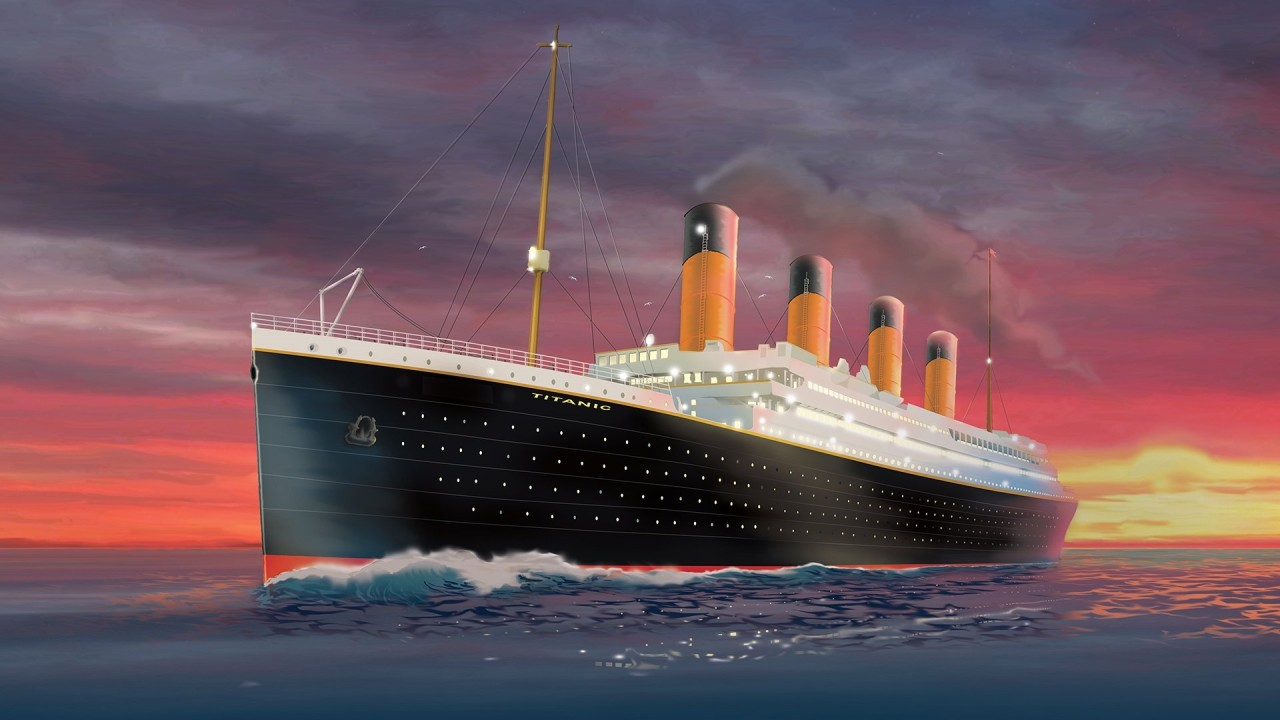

### 🛳️Titan🛳️ ML Lab project ###
By Ben, Dana and Aviv

### 1. Data analysis ###

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Starting with importing the data CSV file and look at the data
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
train_df.describe() #only number values 

In [ ]:
train_df.head(100)

In [ ]:
# Searching for Nan/ Null value to understand the data
train_df.isna().sum()

In [ ]:
# There are lot of Nan in our data set, so we will give a solution for those empty values
print(train_df.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).round(1))

In [ ]:
# Lets see the mean ages for "Miss" (for example) to fill the missing age values compare to "Mr"

print ("Avg age of 'Miss' Title", round(train_df[train_df['Name'].str.contains('Miss')]['Age'].mean()))
print ("Avg age of 'Mr' Title", round(train_df[train_df['Name'].str.contains('Mr')]['Age'].mean()))
print ("Avg age of 'Mrs' Title", round(train_df[train_df['Name'].str.contains('Mrs')]['Age'].mean()))
print ("Avg age of 'Master' Title", round(train_df[train_df['Name'].str.contains('Master')]['Age'].mean()))

# to fill the nan valuse of Age in the data frame - we can clearly see that we need to fill it wisely by the title (part of sex definiton) as they are diffrent from each other

In [ ]:
#extract a title for each Name in the train and test datasets
for dataset in [train_df,test_df]:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df['Title'], train_df['Sex'])

In [ ]:
#replace various titles with more common names
for dataset in [train_df,test_df]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona','Countess', 'Lady', 'Sir'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

In [ ]:
# we will simplify the name_title to replace Nan ages with more generic name_tilte
mean_age_df = train_df[['Title', 'Age']].groupby(['Title'], as_index=False).mean()
mean_age_df

# Define a function to replace NaN values in 'Age' column based on title
def replace_nan_age(row):
    if pd.isnull(row['Age']):
        return mean_age_df.loc[mean_age_df['Title'] == row['Title'], 'Age'].values[0]
    else:
        return row['Age']

# Apply the function to replace NaN values in 'Age' column of train_set and test_df
train_df['Age'] = train_df.apply(replace_nan_age, axis=1)
test_df['Age'] = test_df.apply(replace_nan_age, axis=1)

# Now, let's confirm that there are no more NaN values in 'Age' column
print(f"number of nan Age: {test_df['Age'].isnull().sum()}" )  # This should output 0 if all NaN values are replaced
test_df.head(10)

In [ ]:
# Now, let's confirm that there are no more NaN values in 'Age' column
print(f"The number of nan Age: {train_df['Age'].isnull().sum()}" )  # This should output 0 if all NaN values are replaced
train_df.head(10)

In [ ]:
#now we need to fill in the missing values in the Embarked feature

print("Number of people embarking in Southampton (S):")
southampton = train_df[train_df["Embarked"] == "S"].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg (C):")
cherbourg = train_df[train_df["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown (Q):")
queenstown = train_df[train_df["Embarked"] == "Q"].shape[0]
print(queenstown)

#Replacing the missing values in the Embarked feature with S, because Southampton is the most embarked value 
train_df = train_df.fillna({"Embarked": "S"})
test_df = test_df.fillna({"Embarked": "S"})

In [ ]:
# Searching for Nan/ Null value to understand the data
train_df.isna().sum()
test_df.isna().sum()

In [ ]:
#now we need to fill in the missing value in the fare feature but only for the test set. We will replace the empty value with the mean fair.
test_df = test_df.fillna({"Fare": test_df['Fare'].mean()})

In [ ]:
# Analysis Cabin None's
import seaborn as sns
import matplotlib.pyplot as plt 

cabin_col = train_df.Cabin.apply(lambda x: str(x)[0])
cabin_col = cabin_col[cabin_col != 'n']
print(cabin_col.value_counts())


In [ ]:
#Droping Cabin None
#The Cabin feature is missing most of its values (77%), it would be hard to fill them with helpful information so we decided to drop this feature
#We will also drop the Ticket and PassengerID values since they are just the representative number and not informative
#Regarding the dropping Name colum, we extract the common inforamation in to "title" and we will use it for the model
train_PassengerId = test_df['PassengerId']
train_df.drop(['Ticket','Cabin','PassengerId','Name'],axis=1,inplace=True)
# dropping the same for the test set
test_PassengerId = test_df['PassengerId']
test_df.drop(['Ticket','Cabin','PassengerId','Name'],axis=1,inplace=True)

In [ ]:
print(train_df.columns)
print(test_df.columns)

In [ ]:
#Plotting correlation graph
#I will mention that there is a warning red message, it's only a warning for strings values in the data set.
sns.pairplot(data=train_df, hue='Survived')
plt.show()

In [ ]:
from sklearn import preprocessing

def convert_one_hot_enc(df):
    # Initialize the OneHotEncoder
    encoder = preprocessing.OneHotEncoder(drop='first')
    # Fit and transform the data
    encoded_data = encoder.fit_transform(df[['Title','Sex','Embarked']])
    # Convert the sparse matrix into a dense array and create a DataFrame
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Title','Sex','Embarked']))

    df.drop(['Title','Sex','Embarked'],axis=1,inplace=True)
    merged_df = pd.concat([df, encoded_df], axis=1)
    return merged_df

In [ ]:
target_df = train_df['Survived'] 
train_df.drop(['Survived'], axis=1, inplace=True)

train_df = convert_one_hot_enc(train_df)
test_df = convert_one_hot_enc(test_df)
train_df.shape,test_df.shape

### 2. Choice of ML ###

In [ ]:
# Split the data
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df, target_df, test_size=0.20, random_state=42)

### MLP vs. Logistic Regression ###

We chose for the MLP model due to its wide spread usage as a neural network model in various industries.It has been proven to be a best practice in many scenarios. MLPs are popular because they are versatile and can handle complex relationships within the data.

In [ ]:
# MLP model 
from sklearn import neural_network
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

MLP_model = neural_network.MLPClassifier(alpha=1e-5,hidden_layer_sizes=(15,),
                                                   random_state=1,max_iter=1000)
MLP_model.fit(X_train, y_train)

predictions_mlp_val = MLP_model.predict(X_val)
predictions_mlp_train = MLP_model.predict(X_train)
acc_mlp_val = metrics.accuracy_score(y_val, predictions_mlp_val)
acc_mlp_train = metrics.accuracy_score(y_train, predictions_mlp_train)
print(f"MLP validation accuracy: {acc_mlp_val:.3f}, MLP training accuracy: {acc_mlp_train:.3f} ")

y_pred_MLP = MLP_model.predict(X_val)
MLP_confusion_matrix = metrics.confusion_matrix(y_val, y_pred_MLP)

plt.figure()
sns.heatmap(MLP_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=MLP_model.classes_, yticklabels=MLP_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-MLP')

In [ ]:
# Before train and choose the MLP, we will show the differences in using the features scaled or not scaled.
# Since the values in the data are in different ranges, the NN is sensitive to this combination into one model and big numbers can cause bias issue.

scaler = StandardScaler() # Scaling transform and normelize the values in the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
test_df_scale = scaler.transform(test_df)

MLP_model.fit(X_train, y_train)

predictions_mlp_val = MLP_model.predict(X_val)
predictions_mlp_train = MLP_model.predict(X_train)
acc_mlp_val_scale = metrics.accuracy_score(y_val, predictions_mlp_val)
acc_mlp_train_scale = metrics.accuracy_score(y_train, predictions_mlp_train)
print(f"MLP scaled feature validation accuracy: {acc_mlp_val_scale:.3f}, MLP training accuracy: {acc_mlp_train_scale:.3f} ")
print(f"MLP scaled feature \n\n\t validation accuracy improvment: {(acc_mlp_val_scale-acc_mlp_val)/acc_mlp_val*100:.3f}%, MLP training accuracy improvment: {(acc_mlp_train_scale-acc_mlp_train)/acc_mlp_train:.3f} ")

y_pred_MLP = MLP_model.predict(X_val)
MLP_confusion_matrix = metrics.confusion_matrix(y_val, y_pred_MLP)

plt.figure()
sns.heatmap(MLP_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=MLP_model.classes_, yticklabels=MLP_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-MLP')

### KNN vs. NBC ###
1. Titanic dataset is small (approximately 850), NBC might require more data to estimate probabilities accurately, especially if there are many features with high dimensionality.
2. KNN might handle them better as it relies on local similarity measures and doesn't assume independence between features. NBC might be sensitive to irrelevant features, as it assumes feature independence.
3. As we saw in the scatter plot when we analyzed our data, we can clearly see that we can classify our data into a few clusters, as each cluster is unique among the data. The clusters help to distinguish between the features and aid in understanding the model's estimation and prediction.

In [ ]:
# KNN model 
from sklearn import neighbors

KNN_model = neighbors.KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(X_train, y_train)

predictions_KNN_val = KNN_model.predict(X_val)
predictions_KNN_train = KNN_model.predict(X_train)
acc_KNN_val = metrics.accuracy_score(y_val, predictions_KNN_val)
acc_KNN_train = metrics.accuracy_score(y_train, predictions_KNN_train)
print(f"KNN validation accuracy: {acc_KNN_val:.3f}, KNN training accuracy: {acc_KNN_train:.3f} ")

knn_confusion_matrix = metrics.confusion_matrix(y_val, predictions_KNN_val)

plt.figure()
sns.heatmap(knn_confusion_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=KNN_model.classes_, yticklabels=KNN_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-KNN')

### 3. ML Tuning ###

### MLP Classifier Grid search ###

In [ ]:
# Checking different learning rate types and hidden layer sizes 
# in order to find the the combination with the best accuracy rate.

# Grid Search
ls_max= [0,0,0,0]
for solver_type in ['sgd', 'adam']:
    for lr_type in ['constant','invscaling','adaptive']:
        for layer in [5,10,15,60,70,80]:
            clf_2 = neural_network.MLPClassifier(alpha=1e-5,hidden_layer_sizes=(layer,),
                                                   random_state=1,max_iter=1000,
                                                   solver=solver_type, learning_rate=lr_type)

            clf_2.fit(X_train, y_train) 
            
            predictions_mlp_val = clf_2.predict(X_val)
            predictions_mlp_train = clf_2.predict(X_train)
            acc_mlp_val = metrics.accuracy_score(y_val, predictions_mlp_val)
            acc_mlp_train = metrics.accuracy_score(y_train, predictions_mlp_train)
            if acc_mlp_val > ls_max[0]:
                ls_max = [acc_mlp_val,layer,lr_type,solver_type]
                    
print(f'MLP Grid Search best reults \n LR_type: {ls_max[2]} solver:{ls_max[3]} hidden_layer:{ls_max[1]} validation_accuracy:{ls_max[0]:.3f}')



In [ ]:
# The reason that the 'constant' and 'adaptive' LR_type are the same is because
# The‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ 
# as long as training loss keeps decreasing, so it behave as the 'constant' LR Type

#The best model is :
# Hidden Layer = 15 
# Solver = sgd 
# LR_type = constant
# Since the validation Accuracy is the highest value

train_loss = []
val_loss = []
clf = neural_network.MLPClassifier(alpha=1e-5,hidden_layer_sizes=(15,),
                                       solver='sgd',learning_rate='constant',
                                       random_state=1,max_iter=1000)

# Train the model and record the loss at each iteration
for iteration in range(1, clf.max_iter+1 ):
    clf.partial_fit(X_train, y_train, classes=np.unique(y_train))
    train_loss.append(clf.loss_)
    val_loss.append(log_loss(y_val, clf.predict(X_val)))

#Ploting Train Val loss functions
plt.figure()
plt.plot(range(1,len(clf.loss_curve_)+1), clf.loss_curve_, color='blue', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('MLP Loss Function Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# KNN model

list_acc_knn_val = []
list_acc_knn_train = []

#Grid search Hyper-parameter 
for k in range(2,30):
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=k )
    knn_model.fit(X_train, y_train)

    predictions_knn_val = knn_model.predict(X_val)
    predictions_knn_train = knn_model.predict(X_train)
    acc_knn_val = metrics.accuracy_score(y_val, predictions_knn_val)
    acc_knn_train = metrics.accuracy_score(y_train, predictions_knn_train)
    
    #print(f'KNN k={k} Accuracy train:{acc_knn_train} validation:{acc_knn_val}')
    
    list_acc_knn_val.append(acc_knn_val)
    list_acc_knn_train.append(acc_knn_train)
plt.figure()
plt.plot(range(0, len(list_acc_knn_val)), list_acc_knn_val, color='blue', label='KNN Validation Accuracy')
plt.plot(range(0, len(list_acc_knn_train)), list_acc_knn_train, color='green', label='KNN Train Accuracy')
plt.title('Accuracy vs. K cluster for KNN model')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


print(f'Max Accuracy - Acc:{max(list_acc_knn_val):.4f} K:{ list_acc_knn_val.index(max(list_acc_knn_val))}')

In [ ]:
# We can see the for k=3 we get the best accuracy 
knn_model = neighbors.KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_val)
classification_rep = metrics.classification_report(y_val, y_pred_knn)
print(classification_rep)

In [ ]:
# Comparing MLP vs. KNN models

y_pred_mlp = clf.predict(X_val)
y_pred_knn = knn_model.predict(X_val)

balanced_acc_mlp = metrics.balanced_accuracy_score(y_val, y_pred_mlp)
balanced_acc_knn = metrics.balanced_accuracy_score(y_val, y_pred_knn)
print(f"MLP balanced accuracy: {balanced_acc_mlp:.3f} \nKNN balanced accuracy: {balanced_acc_knn:.3f}")

# Generate confusion matrix
conf_matrix_mlp = metrics.confusion_matrix(y_val, y_pred_mlp)
conf_matrix_knn = metrics.confusion_matrix(y_val, y_pred_knn)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-MLP')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Reds", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-KNN')
plt.show()

In [ ]:
# Feature selection algorithms, Ensembles (Bagging , Boosting)

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Feature selection
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
feature_selector.fit(X_train, y_train)
X_train_selected = feature_selector.transform(X_train)
X_val_selected = feature_selector.transform(X_val)

# Ensemble - Bagging (Random Forest)
bagging_clf = RandomForestClassifier(n_estimators=100, random_state=42)
bagging_clf.fit(X_train_selected, y_train)
y_pred_bagging = bagging_clf.predict(X_val_selected)
accuracy_bagging = metrics.accuracy_score(y_val, y_pred_bagging)
print("Accuracy - Bagging (Random Forest):", accuracy_bagging)

# Ensemble - Boosting (AdaBoost)
boosting_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
boosting_clf.fit(X_train_selected, y_train)
y_pred_boosting = boosting_clf.predict(X_val_selected)
accuracy_boosting = metrics.accuracy_score(y_val, y_pred_boosting)
print("Accuracy - Boosting (AdaBoost):", accuracy_boosting)


Comparing all models from our project we can see that MLP is the best results that give as the best Accuracy

We will use it to subbmit the results

### 4. Submiting the results 👏👏👏

In [ ]:
# Merging train and validation for submiting
X_train_combined = np.concatenate([X_train, X_val])
y_train_combined = np.concatenate([y_train, y_val])

In [ ]:
# After merging train and validation data, for maximaize out data size 
# we will train for the last time our choosen best model
clf.fit(X_train_combined, y_train_combined)

predictions = clf.predict(test_df_scale).astype(int)

In [ ]:
results_df = pd.DataFrame()
results_df['PassengerId'] = test_PassengerId
results_df['Survived'] = predictions
results_df[['PassengerId', 'Survived']].to_csv('./results.csv', index=False)

In [ ]:
# Thank you !